In [105]:
import pandas as pd
import numpy as np
import pickle
from scipy.stats import describe
from scipy.stats import random_correlation
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
reload = False
if reload:
    market_train_df = pd.read_csv('./market_train_df.csv')

In [31]:
market_train_df.head()

,Unnamed: 0,time,assetCode,assetName,volume,close,open,returnsClosePrevRaw1,returnsOpenPrevRaw1,returnsClosePrevMktres1,returnsOpenPrevMktres1,returnsClosePrevRaw10,returnsOpenPrevRaw10,returnsClosePrevMktres10,returnsOpenPrevMktres10,returnsOpenNextMktres10,universe
0,0,2007-02-01 22:00:00+00:00,A.N,Agilent Technologies Inc,2606900.0,32.19,32.17,0.005938,0.005312,NaN,NaN,-0.001860,0.000622,NaN,NaN,0.034672,1.0
1,1,2007-02-01 22:00:00+00:00,AAI.N,AirTran Holdings Inc,2051600.0,11.12,11.08,0.004517,-0.007168,NaN,NaN,-0.078708,-0.088066,NaN,NaN,0.027803,0.0
2,2,2007-02-01 22:00:00+00:00,AAP.N,Advance Auto Parts Inc,1164800.0,37.51,37.99,-0.011594,0.025648,NaN,NaN,0.014332,0.045405,NaN,NaN,0.024433,1.0
3,3,2007-02-01 22:00:00+00:00,AAPL.O,Apple Inc,23747329.0,84.74,86.23,-0.011548,0.016324,NaN,NaN,-0.048613,-0.037182,NaN,NaN,-0.007425,1.0
4,4,2007-02-01 22:00:00+00:00,ABB.N,ABB Ltd,1208600.0,18.02,18.01,0.011791,0.025043,NaN,NaN,0.012929,0.020397,NaN,NaN,-0.017994,1.0


In [223]:
market_train_df.sort_values(by = ['time','assetCode'], inplace = True)

In [224]:
market_train_df.shape

(4064834, 17)

In [225]:
market_train_df.columns

Index(['Unnamed: 0', 'time', 'assetCode', 'assetName', 'volume', 'close',
       'open', 'returnsClosePrevRaw1', 'returnsOpenPrevRaw1',
       'returnsClosePrevMktres1', 'returnsOpenPrevMktres1',
       'returnsClosePrevRaw10', 'returnsOpenPrevRaw10',
       'returnsClosePrevMktres10', 'returnsOpenPrevMktres10',
       'returnsOpenNextMktres10', 'universe'],
      dtype='object')

In [226]:
returns = market_train_df['returnsOpenNextMktres10']
market_train_df = market_train_df[np.abs(returns)<0.4]
len(market_train_df)

4064834

In [227]:
describe(market_train_df['returnsOpenNextMktres10'])

DescribeResult(nobs=4064834, minmax=(-0.3999364597187477, 0.3999833267955341), mean=0.0013820503419345567, variance=0.004306104454815593, skewness=0.14593769714572147, kurtosis=4.423296385152375)

In [228]:
np.sqrt(0.004306104454815593)

0.06562091476667781

In [229]:
# Generate random predicted returns, need to be filled with true predicted returns afterwards
mu = 0.0013820503419345567
sigma = np.sqrt(0.004306104454815593)

def predict_return(market_obs_df,news_obs_df = None):
    return sigma*np.random.randn(len(market_obs_df))+mu

In [230]:
with open('sectorMapping.pkl', 'rb') as f:
    sectorMapping = pickle.load(f)

In [231]:
set(sectorMapping.values())
num_sector = len(set(sectorMapping.values()))

In [244]:
# Generate random predicted correlation matrix,need to be filled with true predicted correlation matrix
def predict_sector_correlation(market_obs_df,news_obs_df = None):
    #eigenvalues = np.linspace(0.00001,10.0**0.3,num_sector)**3
    eigenvalues = np.linspace(0.00001,10.0,num_sector)
    eigenvalues = eigenvalues/eigenvalues.sum()*num_sector
    #plt.plot(eigenvalues)
    #plt.show()
    return random_correlation.rvs(eigenvalues)

In [233]:
def predict_sector_variance(market_obs_df,news_obs_df = None):
    return 0.005*np.random.rand(num_sector)+0.001

In [234]:
def maximize_sharpe_ratio( mean, covariance ):
    nominator = np.dot(np.linalg.inv(covariance),np.array(mean))
    denominator = np.dot(np.dot(np.ones(num_sector),np.linalg.inv(covariance)),np.array(mean))
    return nominator/denominator

In [235]:
def allocate_within_sector( sector_obs_df, sector_weight, optimal_asset_weights ):
    sector_obs_df['rank'] = sector_obs_df['predicted_returns'].rank(ascending = False)
    num_asset = len(sector_obs_df['rank'])
    offset = np.linspace(-0.1,0.1,num_asset)
    for i,asset in enumerate(sector_obs_df['assetCode']):
        #print(sector_obs_df.iloc[i]['rank'])
        optimal_asset_weights[asset] = (sector_weight+offset[int(sector_obs_df.iloc[i]['rank'])-1])/num_asset

In [236]:
np.argsort([-3,1,2,0,5,0.5,7])

array([0, 3, 5, 1, 2, 4, 6], dtype=int64)

In [237]:
def generate_weight_prediction(market_obs_df,news_obs_df = None,predictions_template_df = None):
    if predictions_template_df == None:
        predictions_template_df = market_obs_df['assetCode']
    # Map to sectors
    sectorCode = [sectorMapping[asset[:asset.find('.')] if asset.find('.') != -1 else asset] for asset in market_obs_df['assetCode']]
    market_obs_df['sectorCode'] = sectorCode
    
    # Predict returns
    predicted_returns = predict_return(market_obs_df,news_obs_df)
    market_obs_df['predicted_returns'] = predicted_returns
    market_obs_df['volume_scaled_predicted_returns'] = market_obs_df['volume'] * market_obs_df['predicted_returns']
    sum_scaled_predicted_returns = market_obs_df.groupby(['sectorCode'])['volume_scaled_predicted_returns'].sum()
    sum_volume = market_obs_df.groupby(['sectorCode'])['volume'].sum()
    weighted_sector_predicted_returns = sum_scaled_predicted_returns/sum_volume
    #print(sum_scaled_predicted_returns)
    #print(sum_volume)
    #print(weighted_sector_predicted_returns)
    
    # Predict correlation matrix
    predicted_sector_correlation = predict_sector_correlation(market_obs_df,news_obs_df)
    #print(predicted_sector_correlation)
    #sns.heatmap(predicted_sector_correlation)
    #plt.show()
    
    # Predict variance
    predicted_sector_variance = predict_sector_variance(market_obs_df,news_obs_df)
    predicted_sector_volatility = np.diagflat(np.sqrt(predicted_sector_variance))
    #print(predicted_sector_volatility)
    
    # Calculate predicted covariance
    predicted_sector_covariance = np.dot(np.dot(predicted_sector_volatility,predicted_sector_correlation),predicted_sector_volatility)
    #print(predicted_sector_covariance)
    #print(np.diag(predicted_sector_covariance))
    #sns.heatmap(predicted_sector_covariance)
    #plt.show()
    
    # Solve for optimal sector weighting to maximize Sharpe ratio
    optimal_sector_weights = maximize_sharpe_ratio( weighted_sector_predicted_returns, predicted_sector_covariance )
    #print(optimal_sector_weights)
    #print(optimal_sector_weights.sum())
    
    # Generate final confidence level predictions
    optimal_asset_weights = {}
    for sector in set(sectorMapping.values()):
        sector_obs_df = market_obs_df[market_obs_df['sectorCode']==sector]
        sector_weight = optimal_sector_weights[sector]
        allocate_within_sector( sector_obs_df, sector_weight, optimal_asset_weights )
    #print(len(optimal_asset_weights.values()))
    
    return optimal_asset_weights
    # Switch to DataFrame to comply with the submission format
    #return pd.DataFrame.from_dict({'assetCode':list(optimal_asset_weights.keys()),'confidenceValue':list(optimal_asset_weights.values())})

In [238]:
market_obs_df = market_train_df[market_train_df['time']==market_train_df['time'][0]]

C:\Users\georg\Anaconda3 new\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\georg\Anaconda3 new\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\georg\Anaconda3 new\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

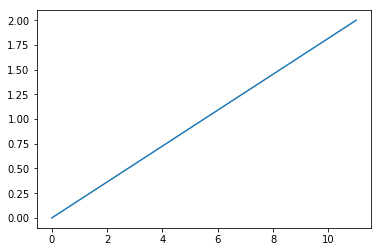

C:\Users\georg\Anaconda3 new\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [239]:
weights = generate_weight_prediction(market_obs_df)

0


C:\Users\georg\Anaconda3 new\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\georg\Anaconda3 new\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\georg\Anaconda3 new\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

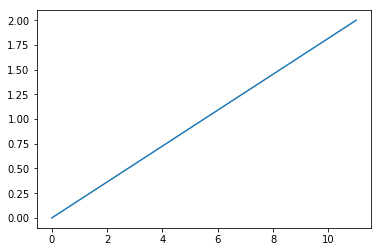

C:\Users\georg\Anaconda3 new\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Done with the weights!
1


C:\Users\georg\Anaconda3 new\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\georg\Anaconda3 new\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


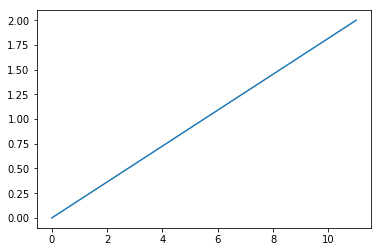

Done with the weights!
2


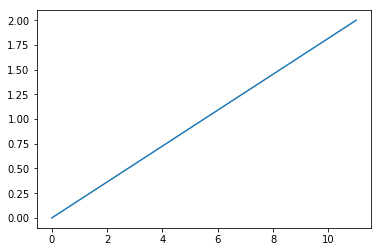

Done with the weights!
3


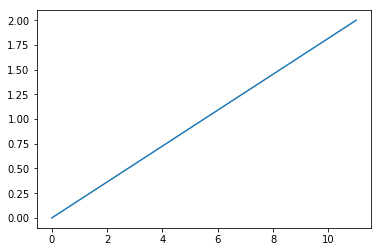

Done with the weights!
4


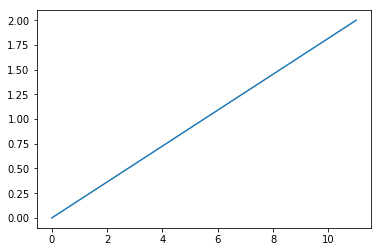

Done with the weights!
5


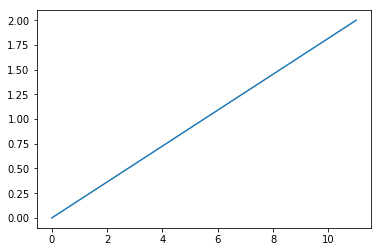

Done with the weights!
6


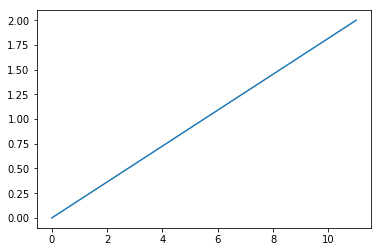

Done with the weights!
7


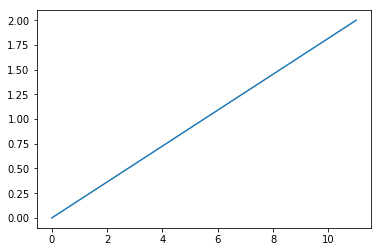

Done with the weights!
8


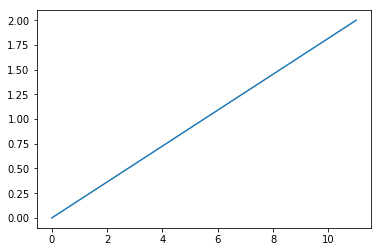

Done with the weights!
9


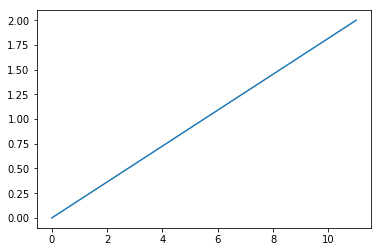

Done with the weights!
10


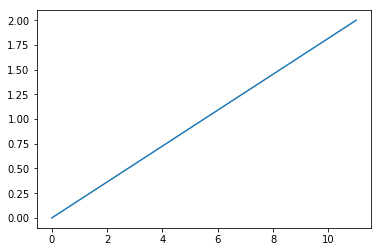

Done with the weights!
11


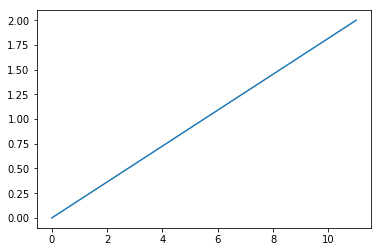

Done with the weights!
12


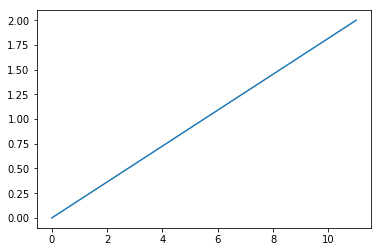

Done with the weights!
13


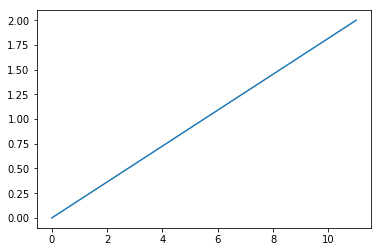

Done with the weights!
14


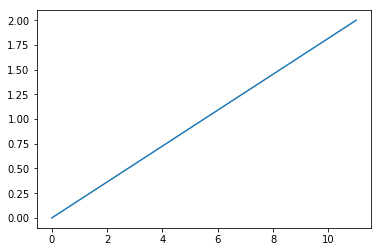

Done with the weights!
15


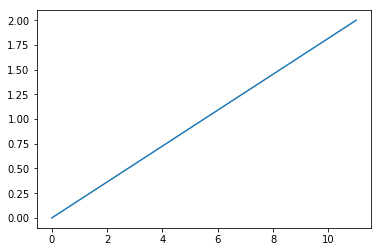

Done with the weights!
16


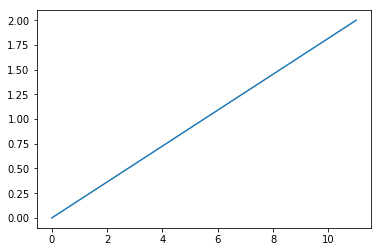

Done with the weights!
17


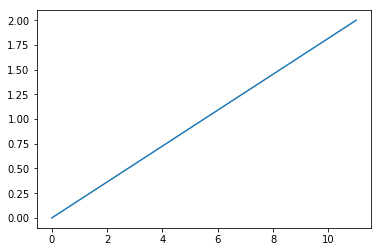

Done with the weights!
18


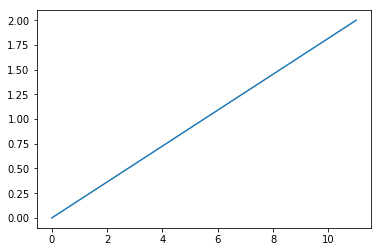

Done with the weights!
19


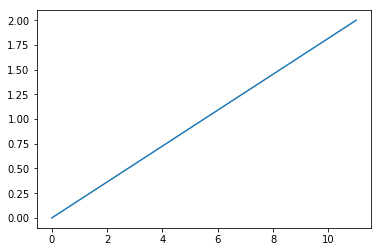

Done with the weights!
20


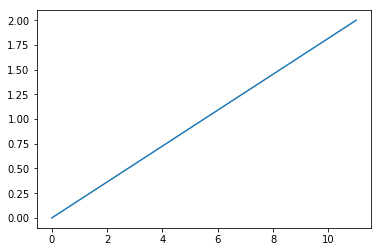

Done with the weights!
21


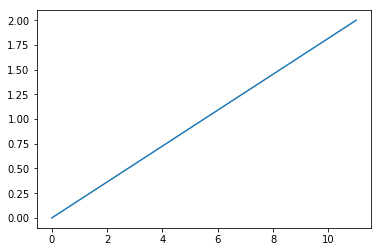

Done with the weights!
22


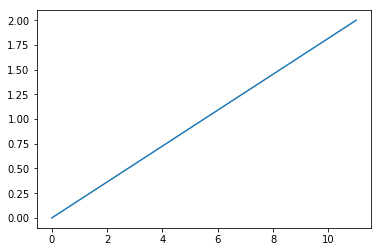

Done with the weights!
23


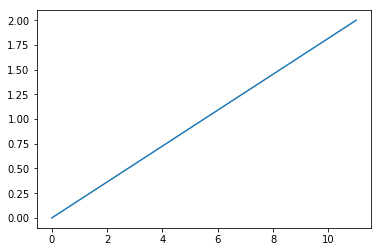

Done with the weights!
24


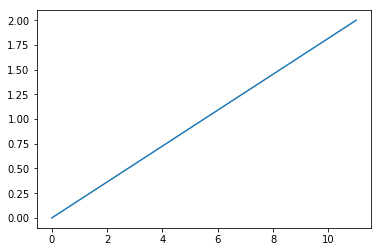

Done with the weights!
25


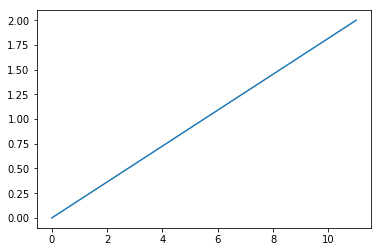

Done with the weights!
26


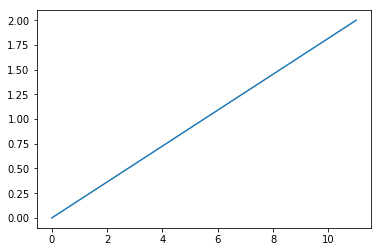

Done with the weights!
27


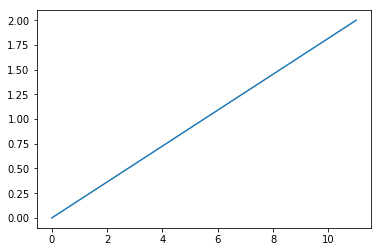

Done with the weights!
28


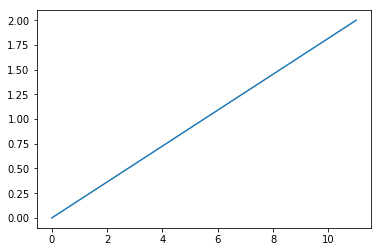

Done with the weights!
29


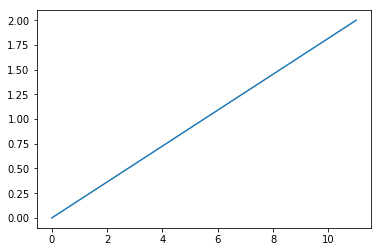

Done with the weights!
30


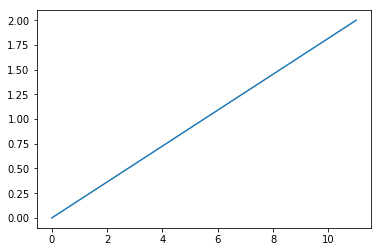

Done with the weights!
31


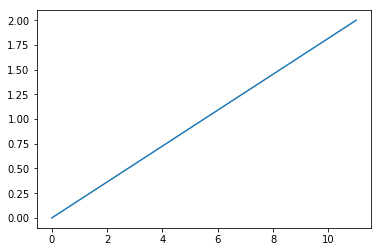

Done with the weights!
32


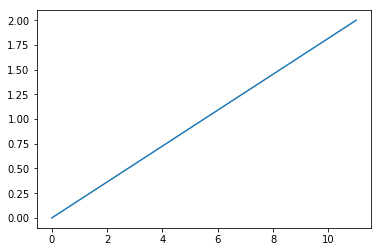

Done with the weights!
33


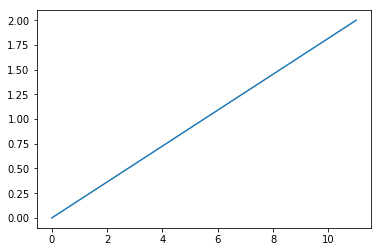

Done with the weights!
34


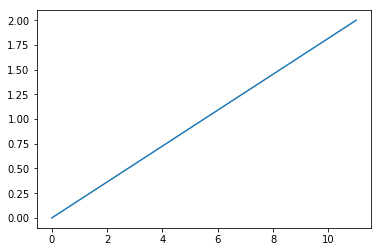

Done with the weights!
35


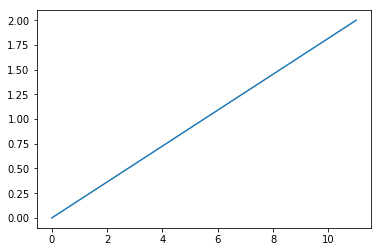

Done with the weights!
36


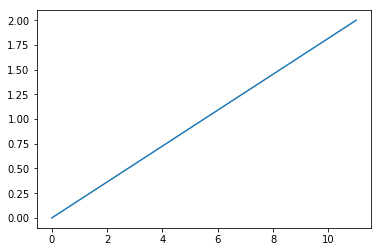

Done with the weights!
37


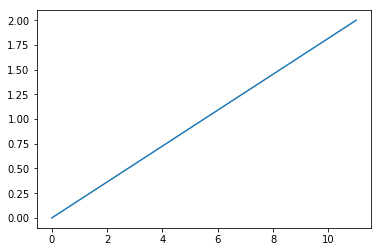

Done with the weights!
38


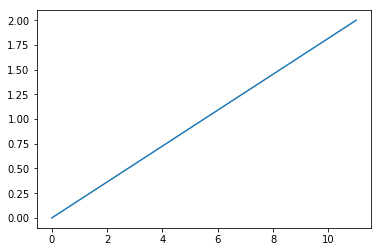

Done with the weights!
39


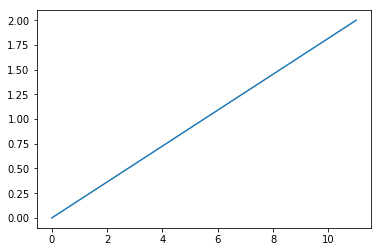

Done with the weights!
40


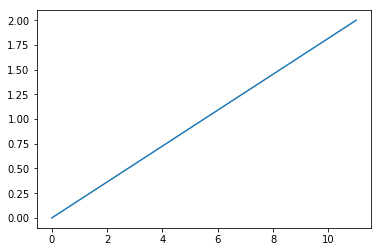

Done with the weights!
41


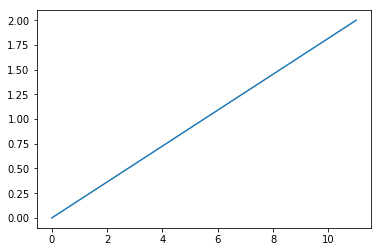

Done with the weights!
42


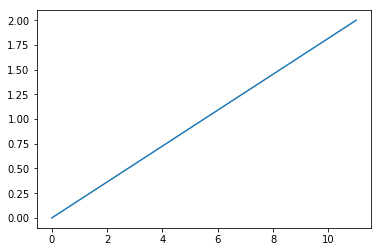

Done with the weights!
43


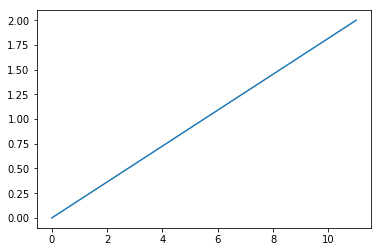

Done with the weights!
44


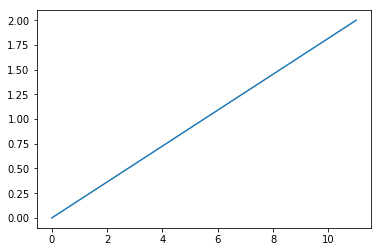

Done with the weights!
45


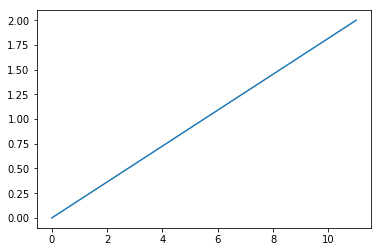

Done with the weights!
46


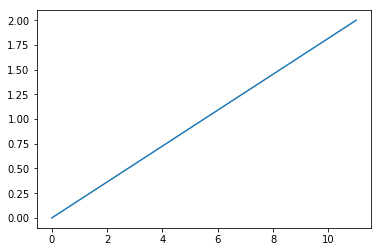

Done with the weights!
47


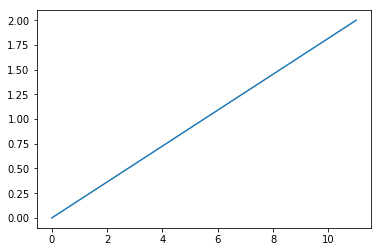

Done with the weights!
48


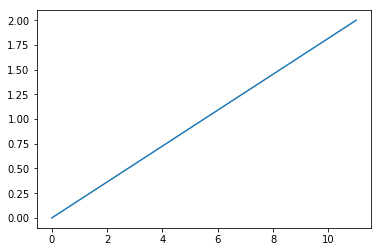

Done with the weights!
49


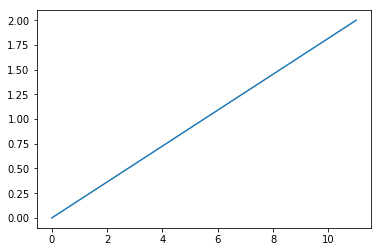

Done with the weights!
50


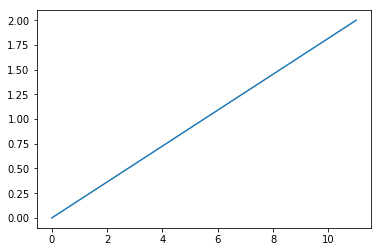

Done with the weights!
51


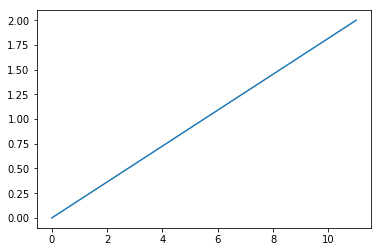

Done with the weights!
52


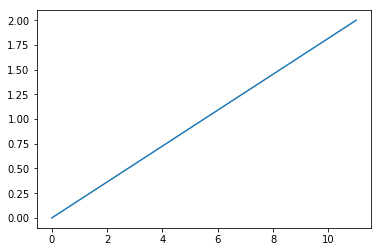

Done with the weights!
53


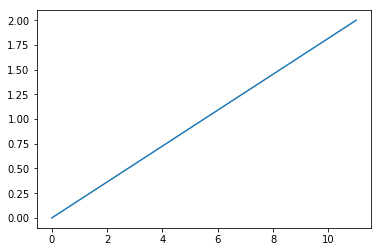

Done with the weights!
54


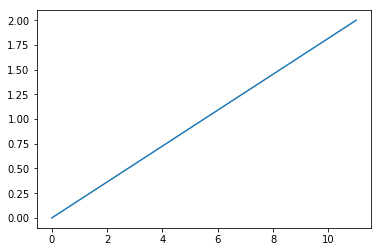

Done with the weights!
55


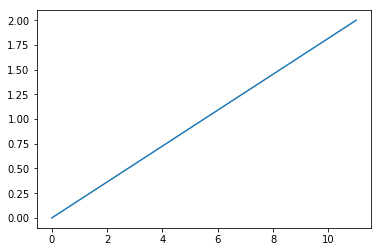

Done with the weights!
56


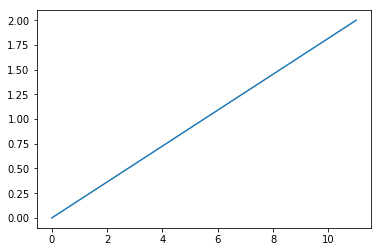

Done with the weights!
57


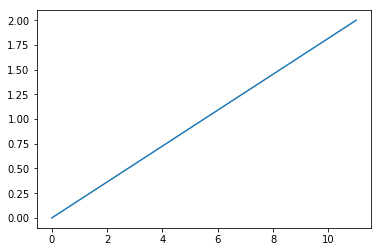

Done with the weights!
58


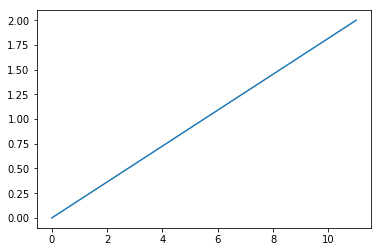

Done with the weights!
59


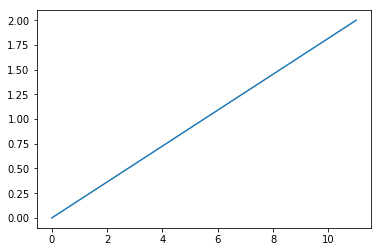

Done with the weights!
60


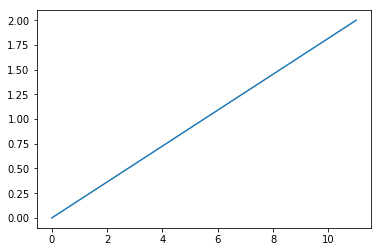

Done with the weights!
61


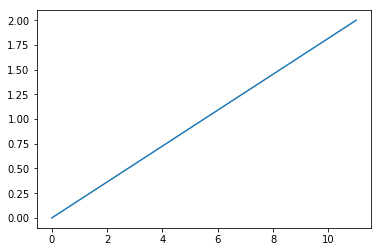

Done with the weights!
62


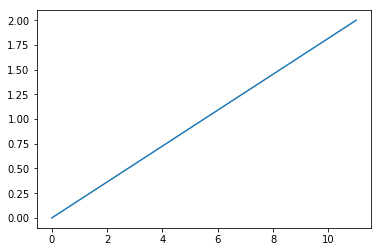

Done with the weights!
63


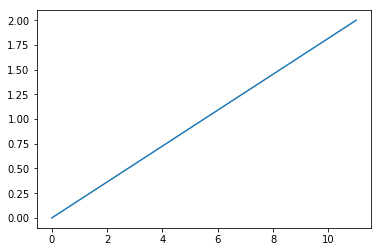

Done with the weights!
64


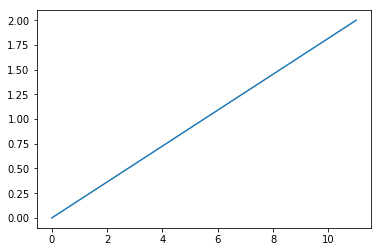

Done with the weights!
65


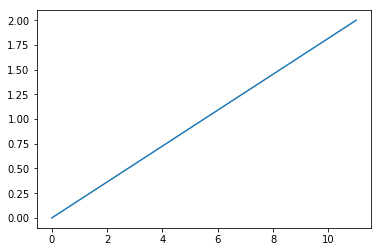

Done with the weights!
66


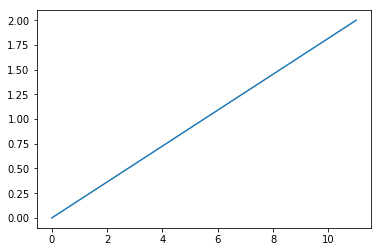

Done with the weights!
67


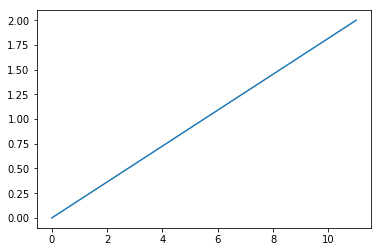

Done with the weights!
68


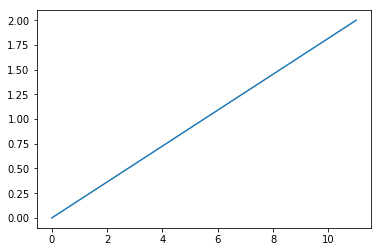

Done with the weights!
69


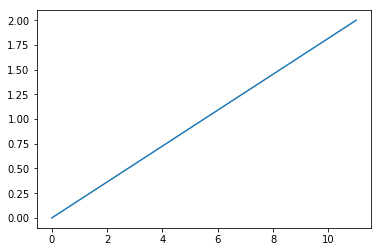

Done with the weights!
70


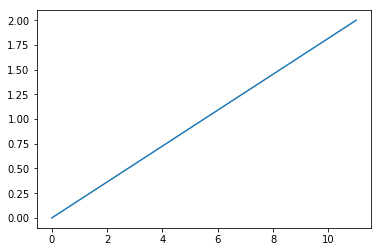

Done with the weights!
71


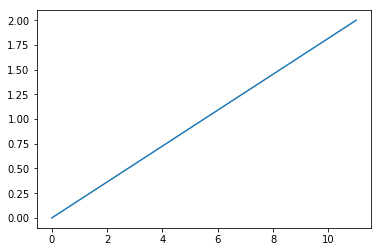

Done with the weights!
72


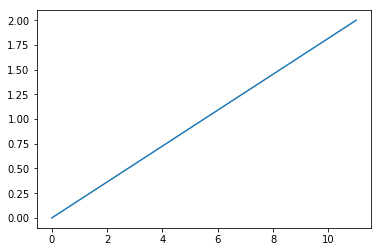

Done with the weights!
73


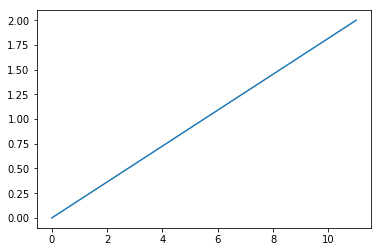

Done with the weights!
74


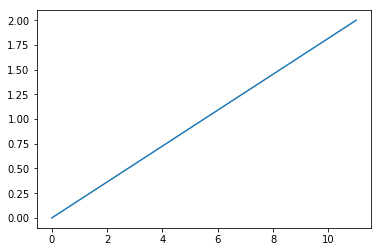

Done with the weights!
75


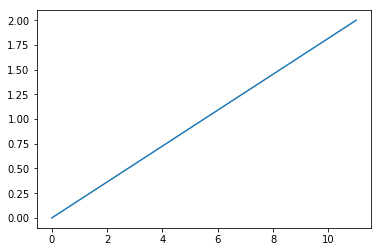

Done with the weights!
76


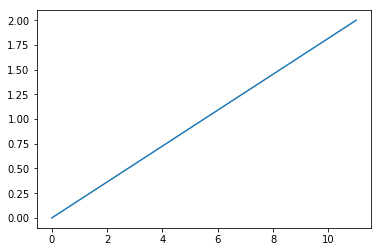

Done with the weights!
77


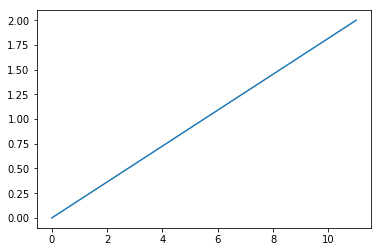

Done with the weights!
78


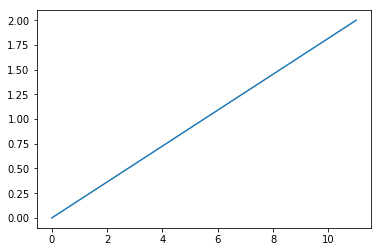

Done with the weights!
79


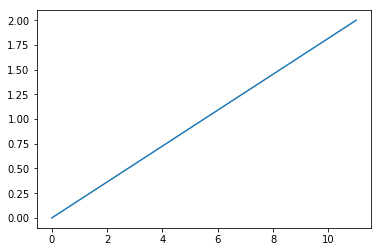

Done with the weights!
80


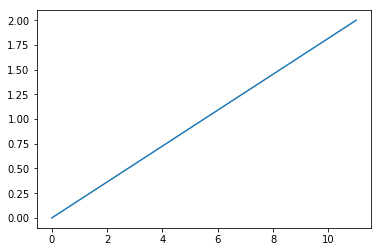

Done with the weights!
81


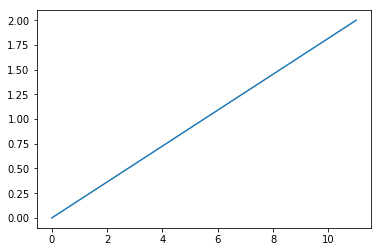

Done with the weights!
82


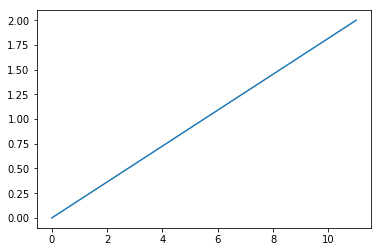

Done with the weights!
83


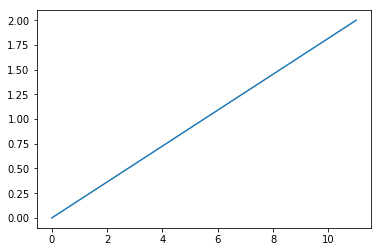

Done with the weights!
84


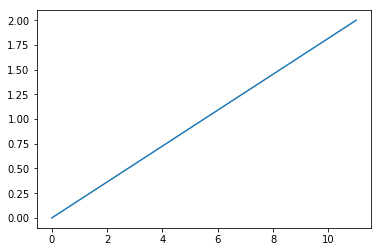

Done with the weights!
85


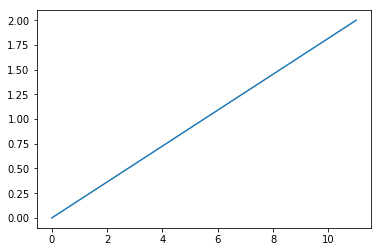

Done with the weights!
86


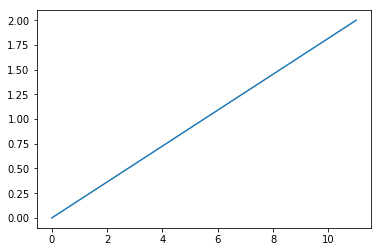

Done with the weights!
87


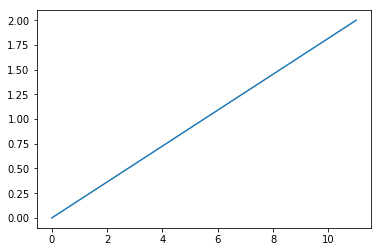

Done with the weights!
88


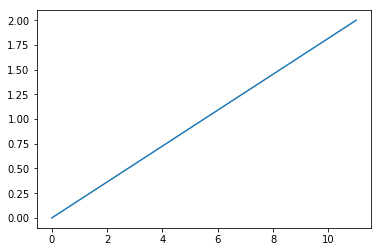

Done with the weights!
89


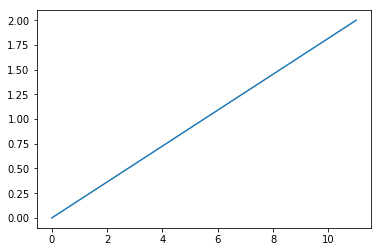

Done with the weights!
90


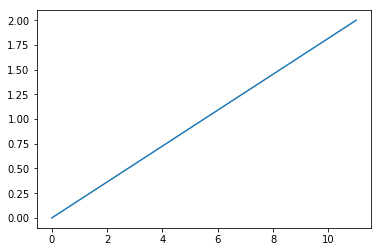

Done with the weights!
91


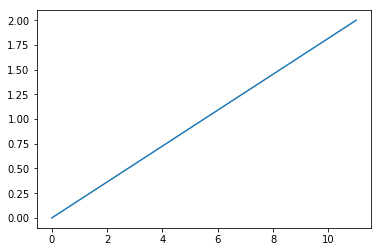

Done with the weights!
92


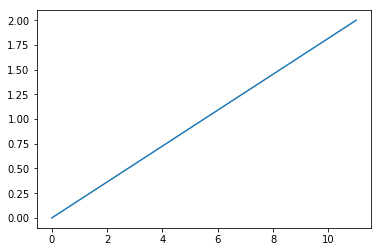

Done with the weights!
93


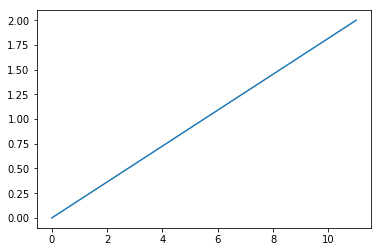

Done with the weights!
94


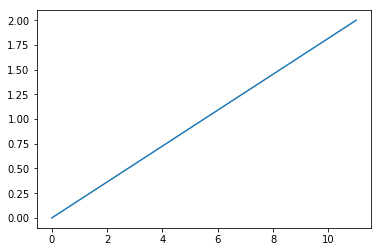

Done with the weights!
95


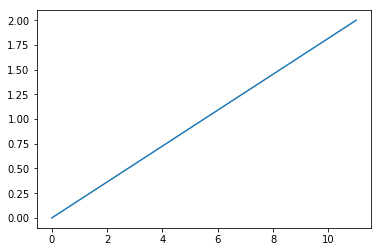

Done with the weights!
96


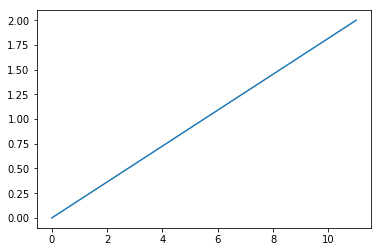

Done with the weights!
97


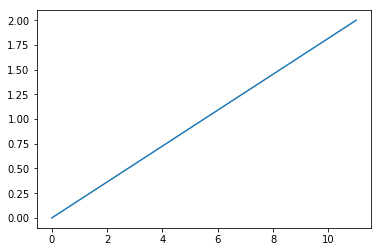

Done with the weights!
98


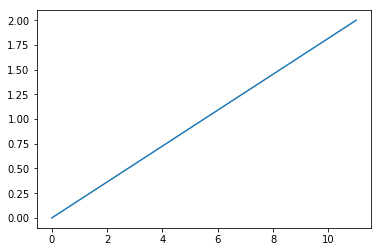

Done with the weights!
99


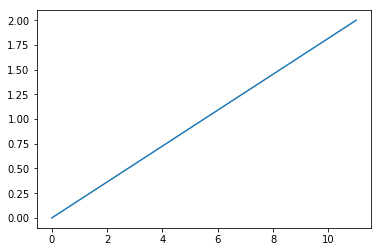

Done with the weights!


In [243]:
portfolio_returns = []
for j,time in enumerate(market_train_df['time'][:100]):
    print(j)
    market_obs_df = market_train_df[market_train_df['time']==market_train_df['time'][0]]
    weights = generate_weight_prediction(market_obs_df)
    print('Done with the weights!')
    market_obs_df['confidenceValue'] = weights.values() # make sure weights is the same order as assetCode
    market_obs_df['x_i'] = market_obs_df['confidenceValue']*market_obs_df['returnsOpenNextMktres10']*market_obs_df['universe']
    portfolio_returns.append(market_obs_df['x_i'].sum())

In [245]:
np.mean(portfolio_returns)/np.std(portfolio_returns)

0.15579598054920754

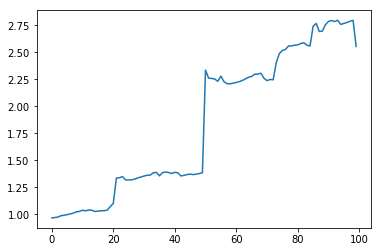

In [248]:
plt.plot(np.cumproduct(1+np.array(portfolio_returns)))

In [242]:
weights

{'AAI.N': 0.0004149456417313567,
 'ABB.N': 0.00026463883902229764,
 'ABD.N': 0.0003913681040515043,
 'ABV.N': 0.00047801555502496195,
 'ABY.N': 0.0003182777372439619,
 'ACF.N': 0.0005239917535006742,
 'ACL.N': 0.0005628946906724306,
 'ACS.N': 0.0004585640864390837,
 'ACTS.O': 0.00031415166814998774,
 'ACXM.O': 0.0002835008691661796,
 'AD.N': 0.0004980564620528364,
 'ADCT.O': 0.0004108195726373826,
 'AEA.N': 0.00029941570710007996,
 'AEOS.O': 0.00042025058770932353,
 'AET.N': 0.00025226063174037515,
 'AF.N': 0.00044913307136714266,
 'AFFX.O': 0.00043852317941120916,
 'AFR.N': 0.0002681754696742755,
 'AGE.N': 0.00026522827746429395,
 'AGU.N': 0.00038252652742155966,
 'AH.N': 0.000375453266117604,
 'AHG.N': 0.0005346016454566078,
 'AHS.N': 0.0004756578012569767,
 'AINV.O': 0.00041376676484736414,
 'AIT.N': 0.00033419257517786224,
 'ALD.N': 0.0003601278666256999,
 'ALU.N': 0.0005752728979543532,
 'AME.N': 0.00037898989676958186,
 'AMLN.O': 0.00033890808271383276,
 'AMMD.O': 0.0003978519269